In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from glob import glob
from random import shuffle
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras import layers,Input

from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import  preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from imgaug import augmenters as iaa
import imgaug as ia
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['model-3', 'model_2.h5', 'wwwkagglecomleekingmodel-1h5', 'histopathologic-cancer-detection']


In [2]:
df_train = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
id_label_map = {k:v for k,v in zip(df_train.id.values, df_train.label.values)}
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1].replace('.tif', '')

In [4]:
labeled_files = glob('../input/histopathologic-cancer-detection/train/*.tif')
test_files = glob('../input/histopathologic-cancer-detection/test/*.tif')

In [5]:
print("labeled_files size :", len(labeled_files))
print("test_files size :", len(test_files))

labeled_files size : 220025
test_files size : 57458


In [6]:
train, val = train_test_split(labeled_files, test_size=0.1, random_state=101010)

In [7]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
def get_seq():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq

def data_gen(list_files, id_label_map, batch_size, augment=False):
    seq = get_seq()
    while True:
        shuffle(list_files)
        for batch in chunker(list_files, batch_size):
            X = [cv2.imread(x) for x in batch]
            Y = [id_label_map[get_id_from_file_path(x)] for x in batch]
            if augment:
                X = seq.augment_images(X)
            X = [preprocess_input(x) for x in X]
                
            yield np.array(X), np.array(Y)
    

In [8]:
def get_model_classif_nasnet():  
    # epoch = 20 ---- 95.87%
    inputs = Input((96, 96, 3))

    x1 = layers.Conv2D(32,3,padding='same')(inputs)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(32,3,padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(32,3,padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.MaxPool2D(2,2)(x1)  


    x2 = layers.Conv2D(64,3,padding='same')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(64,3,padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(64,3,padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    residual_x1 = layers.Conv2D(64,1,strides=1,padding='same')(x1)
    x2 = layers.add([x2,residual_x1])
    x2 = layers.MaxPool2D(2,2)(x2)
    
    
    x2_s = layers.SeparableConv2D(64,3,padding='same')(x2)
    x2_s = layers.BatchNormalization()(x2_s)
    x2_s = layers.Activation('relu')(x2_s)
    x2_s = layers.SeparableConv2D(64,3,padding='same')(x2_s)
    x2_s= layers.BatchNormalization()(x2_s)
    x2_s= layers.Activation('relu')(x2_s)
    x2_s = layers.SeparableConv2D(64,3,padding='same')(x2_s)
    x2_s= layers.BatchNormalization()(x2_s)
    x2_s= layers.Activation('relu')(x2_s)
    x2_s = layers.add([x2_s,x2]) 
    x2_s = layers.MaxPool2D(2,2)(x2_s)
    
    x3 = layers.Conv2D(128,3,padding='same')(x2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(128,3,padding='same')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(128,3,padding='same')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    residual_x2 = layers.Conv2D(128,1,strides=1,padding='same')(x2)
    x3 = layers.add([residual_x2,x3]) 
    
    x3_x3 = layers.Conv2D(128,3,padding='same')(x3)
    x3_x3 = layers.BatchNormalization()(x3_x3)
    x3_x3 = layers.Activation('relu')(x3_x3)
    x3_x3 = layers.Conv2D(128,3,padding='same')(x3_x3)
    x3_x3 = layers.BatchNormalization()(x3_x3)
    x3_x3 = layers.Activation('relu')(x3_x3)
    x3_x3 = layers.Conv2D(128,3,padding='same')(x3_x3)
    x3_x3 = layers.BatchNormalization()(x3_x3)
    x3_x3 = layers.Activation('relu')(x3_x3)
    x3_x3 = layers.add([x3,x3_x3]) 
    x3_x3 = layers.MaxPool2D(2,2)(x3_x3)
    
    
    concetenated_1 = layers.concatenate([x3_x3,x2_s])
    x3_s = layers.SeparableConv2D(128,3,padding='same')(concetenated_1)
    x3_s = layers.BatchNormalization()(x3_s)
    x3_s = layers.Activation('relu')(x3_s)
    x3_s = layers.SeparableConv2D(128,3,padding='same')(x3_s)
    x3_s= layers.BatchNormalization()(x3_s)
    x3_s= layers.Activation('relu')(x3_s)
    x3_s = layers.SeparableConv2D(128,3,padding='same')(x3_s)
    x3_s= layers.BatchNormalization()(x3_s)
    x3_s= layers.Activation('relu')(x3_s)
    x3_s = layers.add([x3_s,x3_x3]) 
    x3_s = layers.MaxPool2D(2,2)(x3_s)
    
    x4 = layers.Conv2D(256,3,padding='same')(x3_x3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(256,3,padding='same')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(256,3,padding='same')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    residual_x3 = layers.Conv2D(256,1,strides=1,padding='same')(x3_x3)
    x4 = layers.add([residual_x3,x4]) 
    
    x4_x4 = layers.Conv2D(256,3,padding='same')(x4)
    x4_x4 = layers.BatchNormalization()(x4_x4)
    x4_x4 = layers.Activation('relu')(x4_x4)
    x4_x4 = layers.Conv2D(256,3,padding='same')(x4_x4)
    x4_x4 = layers.BatchNormalization()(x4_x4)
    x4_x4 = layers.Activation('relu')(x4_x4)
    x4_x4 = layers.Conv2D(256,3,padding='same')(x4_x4)
    x4_x4 = layers.BatchNormalization()(x4_x4)
    x4_x4 = layers.Activation('relu')(x4_x4)
    x4_x4 = layers.add([x4,x4_x4]) 
    x4_x4 = layers.MaxPool2D(2,2)(x4_x4)
    

    concetenated_2 = layers.concatenate([x4_x4,x3_s])
    x4_s = layers.SeparableConv2D(256,3,padding='same')(concetenated_2)
    x4_s = layers.BatchNormalization()(x4_s)
    x4_s = layers.Activation('relu')(x4_s)
    x4_s = layers.SeparableConv2D(256,3,padding='same')(x4_s)
    x4_s= layers.BatchNormalization()(x4_s)
    x4_s= layers.Activation('relu')(x4_s)
    x4_s = layers.SeparableConv2D(256,3,padding='same')(x4_s)
    x4_s= layers.BatchNormalization()(x4_s)
    x4_s= layers.Activation('relu')(x4_s)
    x4_s = layers.add([x4_s,x4_x4]) 
    x4_s = layers.MaxPool2D(2,2)(x4_s)
    
    x5 = layers.Conv2D(512,3,padding='same')(x4_x4)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512,3,padding='same')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512,3,padding='same')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    residual_x4 = layers.Conv2D(512,1,strides=1,padding='same')(x4_x4)
    x5 = layers.add([residual_x4,x5])

    x5_x5 = layers.Conv2D(512,3,padding='same')(x5)
    x5_x5 = layers.BatchNormalization()(x5_x5)
    x5_x5 = layers.Activation('relu')(x5_x5)
    x5_x5 = layers.Conv2D(512,3,padding='same')(x5_x5)
    x5_x5 = layers.BatchNormalization()(x5_x5)
    x5_x5 = layers.Activation('relu')(x5_x5)
    x5_x5 = layers.Conv2D(512,3,padding='same')(x5_x5)
    x5_x5 = layers.BatchNormalization()(x5_x5)
    x5_x5 = layers.Activation('relu')(x5_x5)
    x5_x5 = layers.add([x5,x5_x5])
    x5_x5 = layers.MaxPool2D(2,2)(x5_x5)
    
    concetenated_3 = layers.concatenate([x5_x5,x4_s])
    x5_s = layers.SeparableConv2D(512,3,padding='same')(concetenated_3)
    x5_s = layers.BatchNormalization()(x5_s)
    x5_s = layers.Activation('relu')(x5_s)
    x5_s = layers.SeparableConv2D(512,3,padding='same')(x5_s)
    x5_s= layers.BatchNormalization()(x5_s)
    x5_s= layers.Activation('relu')(x5_s)
    x5_s = layers.SeparableConv2D(512,3,padding='same')(x5_s)
    x5_s= layers.BatchNormalization()(x5_s)
    x5_s= layers.Activation('relu')(x5_s)
    x5_s = layers.add([x5_s,x5_x5]) 

    x = layers.GlobalAveragePooling2D()(x5_s)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)
    
    output_tensor = layers.Dense(1,activation='sigmoid')(x)

    model = Model(inputs,output_tensor)
    
    model.compile(optimizer=Adam(0.01), loss=binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [9]:
def get_model_classif_nasnet_1():  
    
    #epoch = 15 --- 96.31%
    
    inputs = Input((96, 96, 3))

    x1 = layers.Conv2D(32,3,padding='same')(inputs)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(32,3,padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(32,3,padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
#     x1 = layers.MaxPool2D(2,2)(x1)  

    
    x1_s = layers.SeparableConv2D(32,3,padding='same')(inputs)
    x1_s = layers.BatchNormalization()(x1_s)
    x1_s = layers.Activation('relu')(x1_s)
    x1_s = layers.SeparableConv2D(32,3,padding='same')(x1_s)
    x1_s = layers.BatchNormalization()(x1_s)
    x1_s = layers.Activation('relu')(x1_s)    
    x1_s = layers.SeparableConv2D(32,3,padding='same')(x1_s)
    x1_s = layers.BatchNormalization()(x1_s)
    x1_s = layers.Activation('relu')(x1_s)
    concetenated_0 = layers.concatenate([x1,x1_s])

    x2 = layers.Conv2D(64,3,padding='same')(concetenated_0)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(64,3,padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.Conv2D(64,3,padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    residual_concetenated_0 = layers.Conv2D(64,1,strides=1,padding='same')(concetenated_0)
    x2 = layers.add([x2,residual_concetenated_0])
    concetenates_x2_x1_s = layers.concatenate([x2,x1_s])
    x2 = layers.MaxPool2D(2,2)(concetenates_x2_x1_s)
    
    

    x2_s = layers.SeparableConv2D(64,3,padding='same')(x2)
    x2_s = layers.BatchNormalization()(x2_s)
    x2_s = layers.Activation('relu')(x2_s)
    x2_s = layers.SeparableConv2D(64,3,padding='same')(x2_s)
    x2_s= layers.BatchNormalization()(x2_s)
    x2_s= layers.Activation('relu')(x2_s)
    x2_s = layers.SeparableConv2D(64,3,padding='same')(x2_s)
    x2_s= layers.BatchNormalization()(x2_s)
    x2_s= layers.Activation('relu')(x2_s)
    x2_s = layers.Conv2D(96,1,strides=1,padding='same')(x2_s)
    x2_s = layers.add([x2_s,x2]) 
    x2_s = layers.MaxPool2D(2,2)(x2_s)
    
    x3 = layers.Conv2D(128,3,padding='same')(x2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(128,3,padding='same')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x3 = layers.Conv2D(128,3,padding='same')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    residual_x2 = layers.Conv2D(128,1,strides=1,padding='same')(x2)
    x3 = layers.add([residual_x2,x3]) 
    
    x3_x3 = layers.Conv2D(128,3,padding='same')(x3)
    x3_x3 = layers.BatchNormalization()(x3_x3)
    x3_x3 = layers.Activation('relu')(x3_x3)
    x3_x3 = layers.Conv2D(128,3,padding='same')(x3_x3)
    x3_x3 = layers.BatchNormalization()(x3_x3)
    x3_x3 = layers.Activation('relu')(x3_x3)
    x3_x3 = layers.Conv2D(128,3,padding='same')(x3_x3)
    x3_x3 = layers.BatchNormalization()(x3_x3)
    x3_x3 = layers.Activation('relu')(x3_x3)
    x3_x3 = layers.add([x3,x3_x3]) 
    x3_x3 = layers.MaxPool2D(2,2)(x3_x3)
    
    
    concetenated_1 = layers.concatenate([x3_x3,x2_s])
    x3_s = layers.SeparableConv2D(128,3,padding='same')(concetenated_1)
    x3_s = layers.BatchNormalization()(x3_s)
    x3_s = layers.Activation('relu')(x3_s)
    x3_s = layers.SeparableConv2D(128,3,padding='same')(x3_s)
    x3_s= layers.BatchNormalization()(x3_s)
    x3_s= layers.Activation('relu')(x3_s)
    x3_s = layers.SeparableConv2D(128,3,padding='same')(x3_s)
    x3_s= layers.BatchNormalization()(x3_s)
    x3_s= layers.Activation('relu')(x3_s)
    x3_s = layers.add([x3_s,x3_x3]) 
    x3_s = layers.MaxPool2D(2,2)(x3_s)
    
    x4 = layers.Conv2D(256,3,padding='same')(x3_x3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(256,3,padding='same')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.Conv2D(256,3,padding='same')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    residual_x3 = layers.Conv2D(256,1,strides=1,padding='same')(x3_x3)
    x4 = layers.add([residual_x3,x4]) 
    
    x4_x4 = layers.Conv2D(256,3,padding='same')(x4)
    x4_x4 = layers.BatchNormalization()(x4_x4)
    x4_x4 = layers.Activation('relu')(x4_x4)
    x4_x4 = layers.Conv2D(256,3,padding='same')(x4_x4)
    x4_x4 = layers.BatchNormalization()(x4_x4)
    x4_x4 = layers.Activation('relu')(x4_x4)
    x4_x4 = layers.Conv2D(256,3,padding='same')(x4_x4)
    x4_x4 = layers.BatchNormalization()(x4_x4)
    x4_x4 = layers.Activation('relu')(x4_x4)
    x4_x4 = layers.add([x4,x4_x4]) 
    x4_x4 = layers.MaxPool2D(2,2)(x4_x4)
    

    concetenated_2 = layers.concatenate([x4_x4,x3_s])
    x4_s = layers.SeparableConv2D(256,3,padding='same')(concetenated_2)
    x4_s = layers.BatchNormalization()(x4_s)
    x4_s = layers.Activation('relu')(x4_s)
    x4_s = layers.SeparableConv2D(256,3,padding='same')(x4_s)
    x4_s= layers.BatchNormalization()(x4_s)
    x4_s= layers.Activation('relu')(x4_s)
    x4_s = layers.SeparableConv2D(256,3,padding='same')(x4_s)
    x4_s= layers.BatchNormalization()(x4_s)
    x4_s= layers.Activation('relu')(x4_s)
    x4_s = layers.add([x4_s,x4_x4]) 
    x4_s = layers.MaxPool2D(2,2)(x4_s)
    
    x5 = layers.Conv2D(512,3,padding='same')(x4_x4)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512,3,padding='same')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    x5 = layers.Conv2D(512,3,padding='same')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Activation('relu')(x5)
    residual_x4 = layers.Conv2D(512,1,strides=1,padding='same')(x4_x4)
    x5 = layers.add([residual_x4,x5])

    x5_x5 = layers.Conv2D(512,3,padding='same')(x5)
    x5_x5 = layers.BatchNormalization()(x5_x5)
    x5_x5 = layers.Activation('relu')(x5_x5)
    x5_x5 = layers.Conv2D(512,3,padding='same')(x5_x5)
    x5_x5 = layers.BatchNormalization()(x5_x5)
    x5_x5 = layers.Activation('relu')(x5_x5)
    x5_x5 = layers.Conv2D(512,3,padding='same')(x5_x5)
    x5_x5 = layers.BatchNormalization()(x5_x5)
    x5_x5 = layers.Activation('relu')(x5_x5)
    x5_x5 = layers.add([x5,x5_x5])
    x5_x5 = layers.MaxPool2D(2,2)(x5_x5)
    
    concetenated_3 = layers.concatenate([x5_x5,x4_s])
    x5_s = layers.SeparableConv2D(512,3,padding='same')(concetenated_3)
    x5_s = layers.BatchNormalization()(x5_s)
    x5_s = layers.Activation('relu')(x5_s)
    x5_s = layers.SeparableConv2D(512,3,padding='same')(x5_s)
    x5_s= layers.BatchNormalization()(x5_s)
    x5_s= layers.Activation('relu')(x5_s)
    x5_s = layers.SeparableConv2D(512,3,padding='same')(x5_s)
    x5_s= layers.BatchNormalization()(x5_s)
    x5_s= layers.Activation('relu')(x5_s)
    x5_s = layers.add([x5_s,x5_x5]) 

    x = layers.GlobalAveragePooling2D()(x5_s)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    output_tensor = layers.Dense(1,activation='sigmoid')(x)

    model = Model(inputs,output_tensor)
    
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    return model

In [10]:
model = get_model_classif_nasnet_1()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 96, 96, 32)   155         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1

In [11]:
## first round

# batch_size=128
# h5_path = "model_2.h5"
# checkpoint = ModelCheckpoint(h5_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# history = model.fit_generator(
#     data_gen(train, id_label_map, batch_size, augment=True),
#     validation_data=data_gen(val, id_label_map, batch_size),
#     epochs=15, verbose=1,
#     callbacks=[checkpoint],
#     steps_per_epoch=len(train) // batch_size,
#     validation_steps=len(val) // batch_size)

# model.load_weights(h5_path)

In [12]:
os.listdir('../input/')

['model-3',
 'model_2.h5',
 'wwwkagglecomleekingmodel-1h5',
 'histopathologic-cancer-detection']

In [13]:
# # second round 

# model.load_weights('../input/wwwkagglecomleekingmodel-1h5/model_1.h5')
# batch_size=128
# h5_path = "model_2.h5"
# checkpoint = ModelCheckpoint(h5_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


# history = model.fit_generator(
#     data_gen(train, id_label_map, batch_size, augment=True),
#     validation_data=data_gen(val, id_label_map, batch_size),
#     epochs=15, verbose=1,
#     callbacks=[checkpoint],
#     steps_per_epoch=len(train) // batch_size,
#     validation_steps=len(val) // batch_size)



In [14]:
# Third round

model.load_weights('../input/model-3/model_3.h5')
batch_size=128
h5_path = "model_4.h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=5, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)


Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1547/1547 [==============================] - 2096s 1s/step - loss: 0.1614 - acc: 0.9377 - val_loss: 0.0835 - val_acc: 0.9721

Epoch 00001: val_acc improved from -inf to 0.97209, saving model to model_4.h5
Epoch 2/5
1547/1547 [==============================] - 1785s 1s/step - loss: 0.1600 - acc: 0.9378 - val_loss: 0.0820 - val_acc: 0.9717

Epoch 00002: val_acc did not improve from 0.97209
Epoch 3/5
1547/1547 [==============================] - 1787s 1s/step - loss: 0.1578 - acc: 0.9390 - val_loss: 0.0820 - val_acc: 0.9715

Epoch 00003: val_acc did not improve from 0.97209
Epoch 4/5
1301/1547 [========================>.....] - ETA: 4:41 - loss: 0.1582 - acc: 0.9383

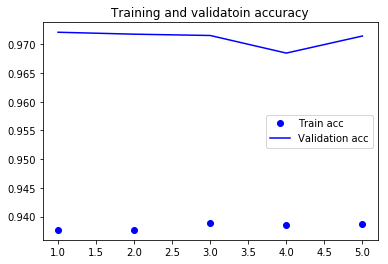

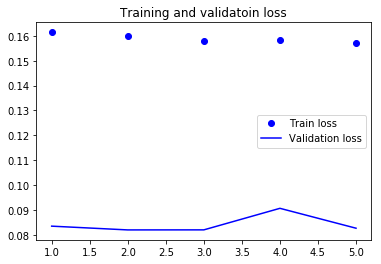

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Train acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validatoin accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Train loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validatoin loss')
plt.legend()

plt.show()

In [16]:
preds = []
ids = []

In [17]:
model.load_weights(h5_path)
for batch in chunker(test_files, batch_size):
    X = [preprocess_input(cv2.imread(x)) for x in batch]
    ids_batch = [get_id_from_file_path(x) for x in batch]
    X = np.array(X)
    preds_batch = ((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    preds += preds_batch
    ids += ids_batch

In [18]:
df = pd.DataFrame({'id':ids, 'label':preds})
df.to_csv("baseline_nasnet.csv", index=False)
df.head()

,id,label
0,485b548a7ee70df49fe7cab6d7062fb8d8f172aa,0.000213
1,0a13be637bd66856953494747e1a56e11e394acc,0.074555
2,1d19c0a74340c60c31b677a0032e710886645bc6,0.043323
3,f45110c8ce329fc4292c2dfb93f1bc73b31d0919,0.999993
4,e07ddd315e3037431689b18b3631c756a7220102,0.005613
